In [50]:
import os
import ee
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd

In [51]:
cwd = "c:\\Users\\m1865\\Desktop\\DISC"
cwd_Images_Raw = cwd + "\\Sentinel-2 Images Raw"
cwd_Images_Processed = cwd + "\\Sentinel-2 Images Processed"

In [52]:
# Create a project called "ee-sentinel-2temporal-nir"
# Google Account is jiawei.gao.polimi@gmail.com
ee.Authenticate(force = False)
ee.Initialize(project='ee-sentinel-2temporal-nir')

In [53]:
date_Start = "2023-01-01"
date_End = "2023-12-31"

In [54]:
# Read the spatial bounding box (30m)
gdf = gpd.read_file(cwd_Images_Processed + "\\San Rossore\\30m.shp")
gdf = gdf.to_crs("EPSG:4326")
bounds = gdf.bounds.values.reshape(-1)
bounds

array([10.29074907, 43.73184403, 10.29112729, 43.73211828])

In [55]:
roi = ee.Geometry.Rectangle([bounds[0],bounds[1],bounds[2],bounds[3]])
roi

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "GeometryConstructors.Polygon",
    "arguments": {
      "coordinates": {
        "constantValue": [
          [
            [
              10.290749070084082,
              43.73211828289707
            ],
            [
              10.290749070084082,
              43.7318440267159
            ],
            [
              10.291127289754002,
              43.7318440267159
            ],
            [
              10.291127289754002,
              43.73211828289707
            ]
          ]
        ]
      },
      "evenOdd": {
        "constantValue": true
      }
    }
  }
})

In [56]:
def mask_s2_clouds(image):
  """Masks clouds in a Sentinel-2 image using the QA band.

  Args:
      image (ee.Image): A Sentinel-2 image.

  Returns:
      ee.Image: A cloud-masked Sentinel-2 image.
  """
  qa = image.select('QA60')

  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloud_bit_mask = 1 << 10
  cirrus_bit_mask = 1 << 11

  # Both flags should be set to zero, indicating clear conditions.
  mask = (
      qa.bitwiseAnd(cloud_bit_mask)
      .eq(0)
      .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
  )

  return image.updateMask(mask)

In [75]:
dataset = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED').filterDate(date_Start, date_End).map(mask_s2_clouds))
filtered = dataset.getRegion(roi, 10).getInfo()
filtered

[['id',
  'longitude',
  'latitude',
  'time',
  'B1',
  'B2',
  'B3',
  'B4',
  'B5',
  'B6',
  'B7',
  'B8',
  'B8A',
  'B9',
  'B11',
  'B12',
  'AOT',
  'WVP',
  'SCL',
  'TCI_R',
  'TCI_G',
  'TCI_B',
  'MSK_CLDPRB',
  'MSK_SNWPRB',
  'QA10',
  'QA20',
  'QA60'],
 ['20230101T102339_20230101T102333_T32TNP',
  10.290785484523797,
  43.731919408799165,
  1672568921419,
  6155,
  7480,
  7392,
  7100,
  7280,
  6868,
  6500,
  7240,
  6116,
  11138,
  5218,
  4117,
  156,
  2094,
  9,
  255,
  255,
  255,
  100,
  0,
  0,
  0,
  0],
 ['20230101T102339_20230101T102333_T32TPP',
  10.290785484523797,
  43.731919408799165,
  1672568916054,
  6162,
  7528,
  7432,
  7148,
  7254,
  6840,
  6485,
  7272,
  6120,
  10839,
  5236,
  4131,
  156,
  2055,
  9,
  255,
  255,
  255,
  100,
  0,
  0,
  0,
  0],
 ['20230103T101411_20230103T101412_T32TNP',
  10.290785484523797,
  43.731919408799165,
  1672741125387,
  4238,
  4156,
  4156,
  4148,
  4139,
  4367,
  4545,
  4544,
  4632,
  1217,
  36

In [58]:
# Read sentinel-2 image with filter
s2 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED").filterDate(date_Start, date_End)
s2

In [59]:
s2_RoI = s2.getRegion(roi, 10).getInfo()

In [60]:
def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms').dt.date

    # Keep the columns of interest.
    df = df[['datetime',  *list_of_bands]]

    return df

In [61]:
def ee_array_to_df_cloud(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['id', 'longitude', 'latitude', *list_of_bands]].dropna()

    # Keep the columns of interest.
    df = df[['id',  *list_of_bands]]

    return df

In [62]:
filtered_B8 = ee_array_to_df_cloud(filtered,['B8'])
filtered_B8

,id,B8
0,20230101T102339_20230101T102333_T32TNP,7240
1,20230101T102339_20230101T102333_T32TPP,7272
2,20230103T101411_20230103T101412_T32TNP,4544
3,20230103T101411_20230103T101412_T32TPP,4760
4,20230106T102411_20230106T102410_T32TNP,4852
...,...,...
3475,20231224T101339_20231224T101542_T32TPP,2496
3476,20231227T102339_20231227T102342_T32TNP,1302
3477,20231227T102339_20231227T102342_T32TPP,1324
3478,20231229T101431_20231229T101426_T32TNP,8096


In [63]:
s2_RoI_B8 = ee_array_to_df(s2_RoI,['B8'])
s2_RoI_B8

,datetime,B8
0,2023-01-01,7240
1,2023-01-01,7272
2,2023-01-03,4544
3,2023-01-03,4760
4,2023-01-06,4852
...,...,...
3475,2023-12-24,2496
3476,2023-12-27,1302
3477,2023-12-27,1324
3478,2023-12-29,8096


In [66]:
df_Merge = pd.concat([s2_RoI_B8['datetime'],filtered_B8],axis= 1)
df_Merge = df_Merge[['datetime','B8']]

In [68]:
df_Merge.sort_values('datetime')
df_Merge_Mean = df_Merge.groupby("datetime").mean().reset_index(drop = False)
df_Merge_Mean

,datetime,B8
0,2023-01-01,7263.666667
1,2023-01-03,4887.333333
2,2023-01-06,4868.666667
3,2023-01-08,7072.833333
4,2023-01-11,2727.25
...,...,...
140,2023-12-19,2280.875
141,2023-12-22,2208.166667
142,2023-12-24,2303.083333
143,2023-12-27,1416.916667


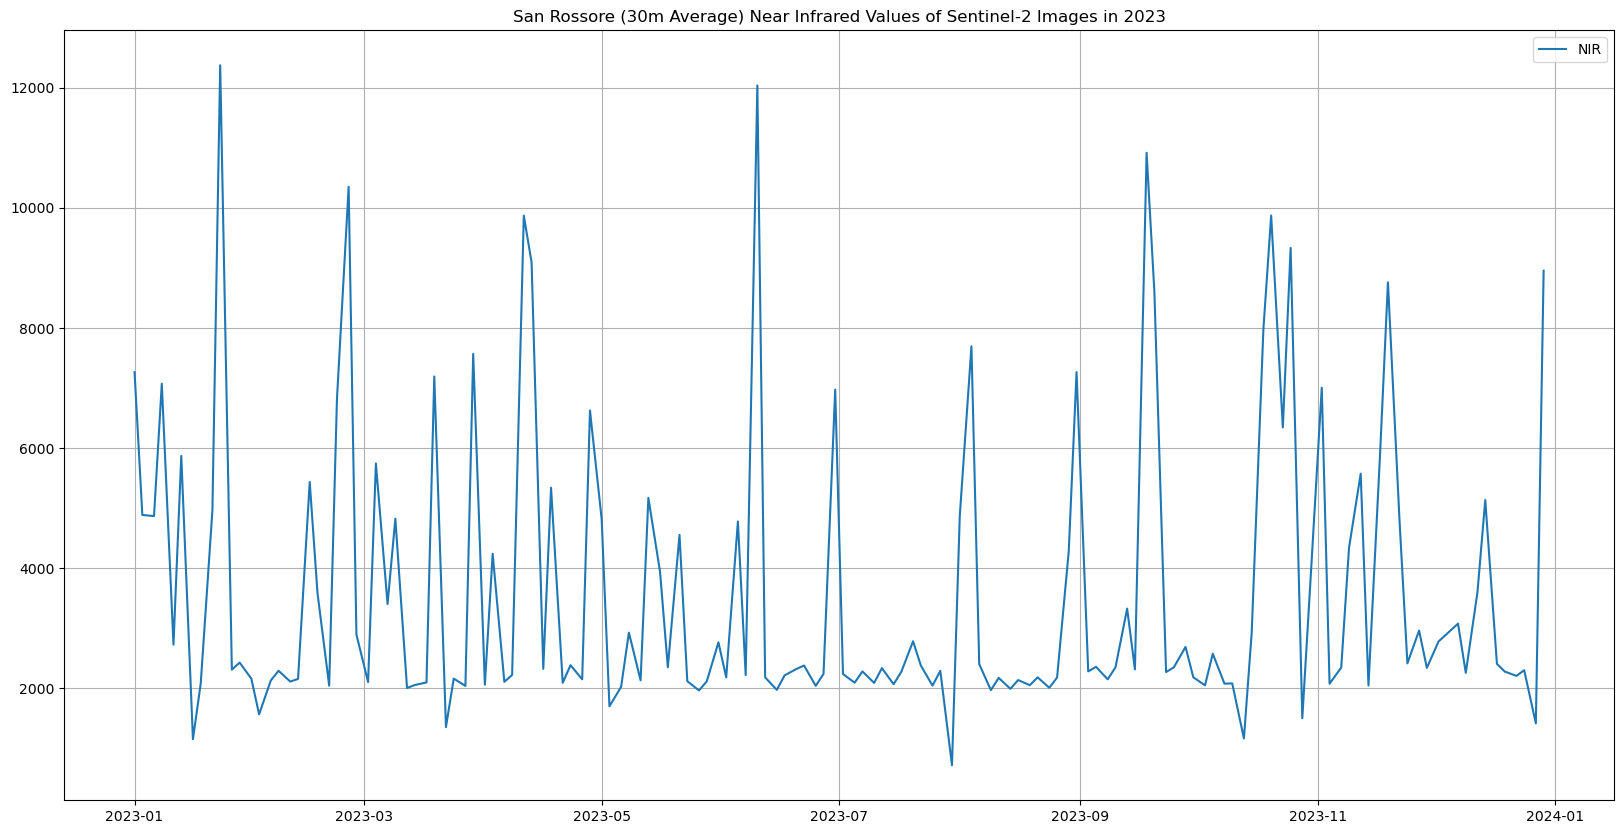

In [70]:
plt.figure(figsize = (20,10))
plt.title("San Rossore (30m Average) Near Infrared Values of Sentinel-2 Images in 2023")
plt.plot(df_Merge_Mean['datetime'], df_Merge_Mean['B8'], label = "NIR")
plt.legend()
plt.grid()

In [69]:
s2_RoI_B8_Mean = s2_RoI_B8.groupby("datetime").mean().reset_index(drop = False)
s2_RoI_B8_Mean

,datetime,B8
0,2023-01-01,7263.666667
1,2023-01-03,4887.333333
2,2023-01-06,4868.666667
3,2023-01-08,7072.833333
4,2023-01-11,2727.250000
...,...,...
140,2023-12-19,2280.875000
141,2023-12-22,2208.166667
142,2023-12-24,2303.083333
143,2023-12-27,1416.916667


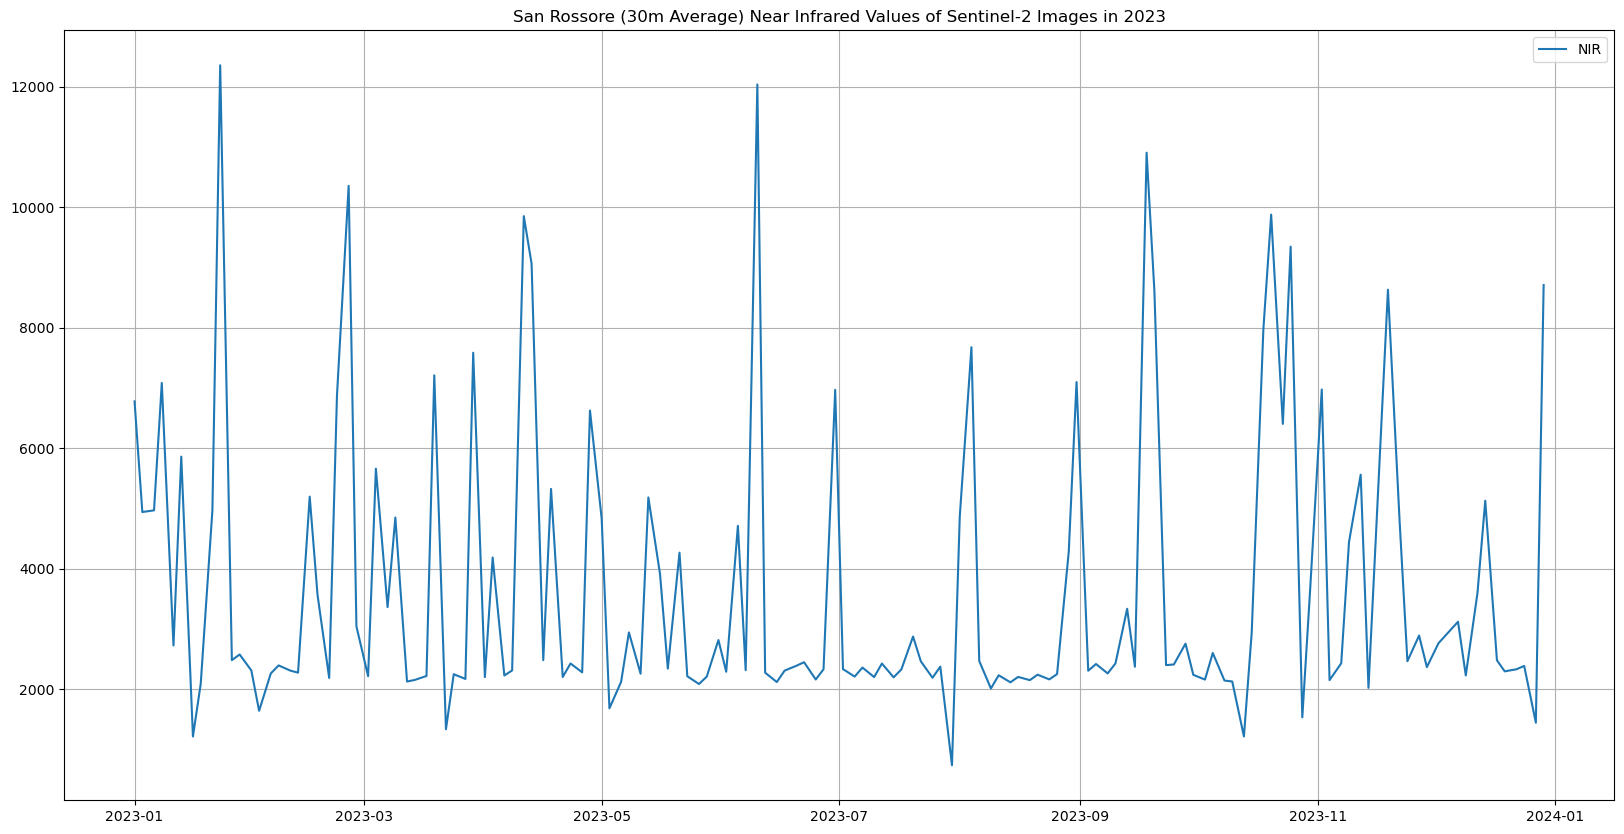

In [89]:
plt.figure(figsize = (20,10))
plt.title("San Rossore (30m Average) Near Infrared Values of Sentinel-2 Images in 2023")
plt.plot(s2_RoI_B8_Mean['datetime'], s2_RoI_B8_Mean['B8'], label = "NIR")
plt.legend()
plt.grid()